In [2]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler1=StandardScaler()
scaler2= MinMaxScaler()

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasClassifier, KerasRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [6]:
# Load the data
df = pd.read_excel('pc_cleaned_2_holiday_season.xlsx')
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df['Temperature Hour'] = df['Temperature'] * df['Hour']
df['GeneralDiffuseFlows^2'] = df['GeneralDiffuseFlows'] * df['GeneralDiffuseFlows']
df[ 'GeneralDiffuseFlows Hour'] = df[ 'GeneralDiffuseFlows'] * df['Hour']
df['DiffuseFlows Hour'] = df['DiffuseFlows'] * df['Hour']

df.set_index('Datetime', inplace=True)

# Split the data into train and test sets
train = df[df['Month'] <= 10]
test = df[df['Month'] > 10]

# Define the features and target
X_train = train[['Temperature', 'Humidity', 'GeneralDiffuseFlows', 'Month', 'Hour','Season',
                 'Temperature Hour','GeneralDiffuseFlows^2',
                'GeneralDiffuseFlows Hour','DiffuseFlows Hour']]
y_train = np.sqrt(train['PowerConsumption_Zone1'])
X_test = test[['Temperature', 'Humidity', 'GeneralDiffuseFlows', 'Month', 'Hour','Season',
               'Temperature Hour','GeneralDiffuseFlows^2',
                'GeneralDiffuseFlows Hour','DiffuseFlows Hour']]
y_test = np.sqrt(test['PowerConsumption_Zone1'])


In [7]:
tscv = TimeSeriesSplit( max_train_size=4320*3, n_splits=8,test_size=4320)# 144 samples per day * 30 days = 4320 samples


In [8]:
X_train_normalized = scaler1.fit_transform(X_train)
X_train_reshaped = np.reshape(X_train_normalized, (X_train_normalized.shape[0], 1, X_train_normalized.shape[1]))
# Define the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=64,activation='sigmoid', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
 
# Define a custom transformer for reshaping
class ReshapeTransformer:
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.reshape(X, (X.shape[0], 1, X.shape[1]))
    
pipeline = Pipeline([
    ('scaler', scaler1),
    ('reshape', ReshapeTransformer()),
   ('lstm', KerasRegressor(model=create_lstm_model, epochs=50, batch_size=32, optimizer='adam'))
])
param_grid = {  }



In [9]:


# Perform grid search using GridSearchCV with TimeSeriesSplit and the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred1 = best_model.predict(X_test)


Epoch 1/50
288/288 [==============================] - 1s 1ms/step - loss: 29784.6875
Epoch 2/50
288/288 [==============================] - 0s 1ms/step - loss: 26966.8223
Epoch 3/50
288/288 [==============================] - 0s 1ms/step - loss: 23400.7773
Epoch 4/50
288/288 [==============================] - 0s 1ms/step - loss: 19624.8711
Epoch 5/50
288/288 [==============================] - 0s 1ms/step - loss: 15997.4570
Epoch 6/50
288/288 [==============================] - 0s 1ms/step - loss: 12561.3223
Epoch 7/50
288/288 [==============================] - 0s 1ms/step - loss: 9617.7695
Epoch 8/50
288/288 [==============================] - 0s 1ms/step - loss: 7215.1470
Epoch 9/50
288/288 [==============================] - 0s 1ms/step - loss: 5300.0176
Epoch 10/50
288/288 [==============================] - 0s 1ms/step - loss: 3831.7122
Epoch 11/50
288/288 [==============================] - 0s 2ms/step - loss: 2693.5850
Epoch 12/50
288/288 [==============================] - 0s 2ms/step -

405/405 [==============================] - 1s 1ms/step - loss: 61.9225
Epoch 49/50
405/405 [==============================] - 0s 1ms/step - loss: 61.4500
Epoch 50/50
135/135 [==============================] - 0s 995us/step
Epoch 1/50
405/405 [==============================] - 2s 2ms/step - loss: 29356.3008
Epoch 2/50
405/405 [==============================] - 1s 2ms/step - loss: 24919.8750
Epoch 3/50
405/405 [==============================] - 1s 1ms/step - loss: 19516.4688
Epoch 4/50
405/405 [==============================] - 1s 2ms/step - loss: 14418.9912
Epoch 5/50
405/405 [==============================] - 1s 2ms/step - loss: 10140.7354
Epoch 6/50
405/405 [==============================] - 1s 2ms/step - loss: 6850.8130
Epoch 7/50
405/405 [==============================] - 1s 1ms/step - loss: 4402.5439
Epoch 8/50
405/405 [==============================] - 1s 1ms/step - loss: 2681.9424
Epoch 9/50
405/405 [==============================] - 1s 1ms/step - loss: 1554.3145
Epoch 10/50
405/

405/405 [==============================] - 1s 2ms/step - loss: 84.5853
Epoch 45/50
405/405 [==============================] - 1s 1ms/step - loss: 83.9689
Epoch 46/50
405/405 [==============================] - 1s 1ms/step - loss: 83.3156
Epoch 47/50
405/405 [==============================] - 1s 1ms/step - loss: 82.9017
Epoch 48/50
405/405 [==============================] - 1s 2ms/step - loss: 82.3536
Epoch 49/50
405/405 [==============================] - 1s 2ms/step - loss: 81.8435
Epoch 50/50
135/135 [==============================] - 0s 1ms/step
Epoch 1/50
405/405 [==============================] - 2s 2ms/step - loss: 31155.4199
Epoch 2/50
405/405 [==============================] - 1s 2ms/step - loss: 26622.5898
Epoch 3/50
405/405 [==============================] - 1s 2ms/step - loss: 21090.3066
Epoch 4/50
405/405 [==============================] - 1s 1ms/step - loss: 15774.3262
Epoch 5/50
405/405 [==============================] - 1s 1ms/step - loss: 11172.9678
Epoch 6/50
405/405 [==

405/405 [==============================] - 1s 2ms/step - loss: 135.5294
Epoch 41/50
405/405 [==============================] - 1s 2ms/step - loss: 133.6567
Epoch 42/50
405/405 [==============================] - 1s 1ms/step - loss: 132.0303
Epoch 43/50
405/405 [==============================] - 1s 2ms/step - loss: 130.1032
Epoch 44/50
405/405 [==============================] - 1s 2ms/step - loss: 128.1122
Epoch 45/50
405/405 [==============================] - 1s 2ms/step - loss: 126.2572
Epoch 46/50
405/405 [==============================] - 1s 2ms/step - loss: 124.4022
Epoch 47/50
405/405 [==============================] - 1s 3ms/step - loss: 122.7318
Epoch 48/50
405/405 [==============================] - 1s 3ms/step - loss: 121.4418
Epoch 49/50
405/405 [==============================] - 1s 2ms/step - loss: 120.0222
Epoch 50/50
135/135 [==============================] - 1s 2ms/step
Epoch 1/50
405/405 [==============================] - 2s 2ms/step - loss: 33782.9844
Epoch 2/50
405/405 [

405/405 [==============================] - 1s 2ms/step - loss: 76.8327
Epoch 37/50
405/405 [==============================] - 1s 2ms/step - loss: 75.5483
Epoch 38/50
405/405 [==============================] - 1s 2ms/step - loss: 74.3341
Epoch 39/50
405/405 [==============================] - 1s 2ms/step - loss: 73.3122
Epoch 40/50
405/405 [==============================] - 1s 2ms/step - loss: 72.2535
Epoch 41/50
405/405 [==============================] - 1s 2ms/step - loss: 71.3081
Epoch 42/50
405/405 [==============================] - 1s 2ms/step - loss: 70.4565
Epoch 43/50
405/405 [==============================] - 1s 2ms/step - loss: 69.6750
Epoch 44/50
405/405 [==============================] - 1s 2ms/step - loss: 68.8600
Epoch 45/50
405/405 [==============================] - 1s 2ms/step - loss: 68.1444
Epoch 46/50
405/405 [==============================] - 1s 2ms/step - loss: 67.4901
Epoch 47/50
405/405 [==============================] - 1s 2ms/step - loss: 66.8900
Epoch 48/50
405/

In [10]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {}


In [12]:
# Evaluate the performance on the validation fold (e.g., calculate MSE, R-squared, etc.)
mse = mean_squared_error(y_test, y_pred1)
mae = mean_absolute_error(y_test, y_pred1)
r2 = r2_score(y_test, y_pred1)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)

MSE: 69.19205997843103
MAE: 6.526745430215983
R-squared: 0.7792802020297468


In [13]:
X_train_normalized = scaler1.fit_transform(X_train)
X_train_reshaped = np.reshape(X_train_normalized, (X_train_normalized.shape[0], 1, X_train_normalized.shape[1]))
# Define the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=64,activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
 
# Define a custom transformer for reshaping
class ReshapeTransformer:
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.reshape(X, (X.shape[0], 1, X.shape[1]))
    
pipeline = Pipeline([
    ('scaler', scaler1),
    ('reshape', ReshapeTransformer()),
   ('lstm', KerasRegressor(model=create_lstm_model, epochs=50, batch_size=32, optimizer='adam'))
])
param_grid = {  }



# Perform grid search using GridSearchCV with TimeSeriesSplit and the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred2 = best_model.predict(X_test)


Epoch 1/50
288/288 [==============================] - 1s 2ms/step - loss: 29139.0859
Epoch 2/50
288/288 [==============================] - 0s 1ms/step - loss: 17846.2910
Epoch 3/50
288/288 [==============================] - 0s 1ms/step - loss: 7263.7979
Epoch 4/50
288/288 [==============================] - 0s 1ms/step - loss: 3454.4839
Epoch 5/50
288/288 [==============================] - 0s 1ms/step - loss: 2445.6189
Epoch 6/50
288/288 [==============================] - 0s 1ms/step - loss: 1836.7075
Epoch 7/50
288/288 [==============================] - 0s 1ms/step - loss: 1308.2115
Epoch 8/50
288/288 [==============================] - 0s 1ms/step - loss: 870.6827
Epoch 9/50
288/288 [==============================] - 0s 1ms/step - loss: 546.5589
Epoch 10/50
288/288 [==============================] - 0s 1ms/step - loss: 334.2408
Epoch 11/50
288/288 [==============================] - 0s 1ms/step - loss: 207.8821
Epoch 12/50
288/288 [==============================] - 0s 1ms/step - loss: 1

405/405 [==============================] - 1s 1ms/step - loss: 29.9034
Epoch 49/50
405/405 [==============================] - 1s 1ms/step - loss: 29.7046
Epoch 50/50
135/135 [==============================] - 0s 865us/step
Epoch 1/50
405/405 [==============================] - 1s 1ms/step - loss: 26652.2676
Epoch 2/50
405/405 [==============================] - 1s 1ms/step - loss: 9451.1279
Epoch 3/50
405/405 [==============================] - 1s 1ms/step - loss: 3216.9495
Epoch 4/50
405/405 [==============================] - 1s 1ms/step - loss: 1971.2195
Epoch 5/50
405/405 [==============================] - 1s 1ms/step - loss: 1112.6724
Epoch 6/50
405/405 [==============================] - 1s 1ms/step - loss: 597.7421
Epoch 7/50
405/405 [==============================] - 1s 2ms/step - loss: 342.9163
Epoch 8/50
405/405 [==============================] - 1s 2ms/step - loss: 218.8282
Epoch 9/50
405/405 [==============================] - 1s 2ms/step - loss: 159.3600
Epoch 10/50
405/405 [===

405/405 [==============================] - 1s 1ms/step - loss: 38.5804
Epoch 46/50
405/405 [==============================] - 1s 2ms/step - loss: 38.3039
Epoch 47/50
405/405 [==============================] - 1s 2ms/step - loss: 38.1178
Epoch 48/50
405/405 [==============================] - 1s 2ms/step - loss: 37.9638
Epoch 49/50
405/405 [==============================] - 1s 2ms/step - loss: 37.6216
Epoch 50/50
135/135 [==============================] - 0s 1ms/step
Epoch 1/50
405/405 [==============================] - 2s 2ms/step - loss: 28039.2148
Epoch 2/50
405/405 [==============================] - 1s 2ms/step - loss: 11105.3262
Epoch 3/50
405/405 [==============================] - 1s 2ms/step - loss: 4279.7329
Epoch 4/50
405/405 [==============================] - 1s 2ms/step - loss: 2545.0535
Epoch 5/50
405/405 [==============================] - 1s 2ms/step - loss: 1579.7247
Epoch 6/50
405/405 [==============================] - 1s 2ms/step - loss: 918.7064
Epoch 7/50
405/405 [=====

405/405 [==============================] - 1s 2ms/step - loss: 45.9785
Epoch 43/50
405/405 [==============================] - 1s 2ms/step - loss: 45.5556
Epoch 44/50
405/405 [==============================] - 1s 2ms/step - loss: 45.4914
Epoch 45/50
405/405 [==============================] - 1s 2ms/step - loss: 45.1730
Epoch 46/50
405/405 [==============================] - 1s 2ms/step - loss: 45.0744
Epoch 47/50
405/405 [==============================] - 1s 2ms/step - loss: 44.8812
Epoch 48/50
405/405 [==============================] - 1s 2ms/step - loss: 44.7232
Epoch 49/50
405/405 [==============================] - 2s 4ms/step - loss: 44.4766
Epoch 50/50
135/135 [==============================] - 1s 3ms/step
Epoch 1/50
405/405 [==============================] - 3s 3ms/step - loss: 30096.4219
Epoch 2/50
405/405 [==============================] - 1s 2ms/step - loss: 10181.2607
Epoch 3/50
405/405 [==============================] - 1s 3ms/step - loss: 3432.5173
Epoch 4/50
405/405 [=======

405/405 [==============================] - 1s 3ms/step - loss: 32.7588
Epoch 40/50
405/405 [==============================] - 1s 2ms/step - loss: 32.5426
Epoch 41/50
405/405 [==============================] - 1s 2ms/step - loss: 32.5228
Epoch 42/50
405/405 [==============================] - 1s 2ms/step - loss: 32.3413
Epoch 43/50
405/405 [==============================] - 1s 2ms/step - loss: 32.1376
Epoch 44/50
405/405 [==============================] - 1s 2ms/step - loss: 32.0299
Epoch 45/50
405/405 [==============================] - 1s 2ms/step - loss: 32.0216
Epoch 46/50
405/405 [==============================] - 1s 3ms/step - loss: 31.7531
Epoch 47/50
405/405 [==============================] - 1s 3ms/step - loss: 31.6994
Epoch 48/50
405/405 [==============================] - 1s 2ms/step - loss: 31.6366
Epoch 49/50
405/405 [==============================] - 1s 3ms/step - loss: 31.6457
Epoch 50/50
135/135 [==============================] - 1s 3ms/step
Epoch 1/50
1368/1368 [==========

In [14]:
# Evaluate the performance on the validation fold (e.g., calculate MSE, R-squared, etc.)
mse = mean_squared_error(y_test, y_pred2)
mae = mean_absolute_error(y_test, y_pred2)
r2 = r2_score(y_test, y_pred2)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)

MSE: 271.28047725592376
MAE: 12.73269923881496
R-squared: 0.13462654310528455


In [15]:
X_train_normalized = scaler1.fit_transform(X_train)
X_train_reshaped = np.reshape(X_train_normalized, (X_train_normalized.shape[0], 1, X_train_normalized.shape[1]))
# Define the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=64,activation='tanh', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
 
# Define a custom transformer for reshaping
class ReshapeTransformer:
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.reshape(X, (X.shape[0], 1, X.shape[1]))
    
pipeline = Pipeline([
    ('scaler', scaler1),
    ('reshape', ReshapeTransformer()),
   ('lstm', KerasRegressor(model=create_lstm_model, epochs=50, batch_size=32, optimizer='adam'))
])
param_grid = {  }



# Perform grid search using GridSearchCV with TimeSeriesSplit and the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred3 = best_model.predict(X_test)


Epoch 1/50
288/288 [==============================] - 3s 2ms/step - loss: 29704.2715
Epoch 2/50
288/288 [==============================] - 1s 2ms/step - loss: 25036.0996
Epoch 3/50
288/288 [==============================] - 1s 2ms/step - loss: 20735.3125
Epoch 4/50
288/288 [==============================] - 1s 2ms/step - loss: 17273.0645
Epoch 5/50
288/288 [==============================] - 1s 2ms/step - loss: 14375.9316
Epoch 6/50
288/288 [==============================] - 1s 2ms/step - loss: 11850.5791
Epoch 7/50
288/288 [==============================] - 1s 2ms/step - loss: 9375.2998
Epoch 8/50
288/288 [==============================] - 1s 2ms/step - loss: 6932.9580
Epoch 9/50
288/288 [==============================] - 1s 2ms/step - loss: 4974.6665
Epoch 10/50
288/288 [==============================] - 1s 2ms/step - loss: 3241.2209
Epoch 11/50
288/288 [==============================] - 1s 2ms/step - loss: 1863.0564
Epoch 12/50
288/288 [==============================] - 1s 2ms/step -

405/405 [==============================] - 1s 3ms/step - loss: 33.3745
Epoch 49/50
405/405 [==============================] - 1s 2ms/step - loss: 33.0086
Epoch 50/50
135/135 [==============================] - 2s 2ms/step
Epoch 1/50
405/405 [==============================] - 4s 3ms/step - loss: 28985.3164
Epoch 2/50
405/405 [==============================] - 1s 2ms/step - loss: 22773.1660
Epoch 3/50
405/405 [==============================] - 1s 3ms/step - loss: 17401.1113
Epoch 4/50
405/405 [==============================] - 1s 3ms/step - loss: 13027.8721
Epoch 5/50
405/405 [==============================] - 1s 3ms/step - loss: 8856.2578
Epoch 6/50
405/405 [==============================] - 1s 3ms/step - loss: 5570.8730
Epoch 7/50
405/405 [==============================] - 2s 4ms/step - loss: 3431.8606
Epoch 8/50
405/405 [==============================] - 2s 4ms/step - loss: 1907.3446
Epoch 9/50
405/405 [==============================] - 1s 4ms/step - loss: 934.2068
Epoch 10/50
405/405 

Epoch 45/50
405/405 [==============================] - 1s 2ms/step - loss: 53.7303
Epoch 46/50
405/405 [==============================] - 1s 2ms/step - loss: 53.1418
Epoch 47/50
405/405 [==============================] - 1s 2ms/step - loss: 52.4411
Epoch 48/50
405/405 [==============================] - 1s 2ms/step - loss: 51.8252
Epoch 49/50
405/405 [==============================] - 1s 2ms/step - loss: 51.1779
Epoch 50/50
135/135 [==============================] - 1s 2ms/step
Epoch 1/50
405/405 [==============================] - 3s 2ms/step - loss: 30506.5918
Epoch 2/50
405/405 [==============================] - 1s 3ms/step - loss: 24339.2246
Epoch 3/50
405/405 [==============================] - 1s 2ms/step - loss: 19147.5996
Epoch 4/50
405/405 [==============================] - 1s 4ms/step - loss: 14934.4150
Epoch 5/50
405/405 [==============================] - 1s 3ms/step - loss: 11160.1934
Epoch 6/50
405/405 [==============================] - 1s 3ms/step - loss: 7125.3628
Epoch 7/5

405/405 [==============================] - 1s 3ms/step - loss: 73.1452
Epoch 42/50
405/405 [==============================] - 1s 3ms/step - loss: 71.7096
Epoch 43/50
405/405 [==============================] - 1s 3ms/step - loss: 70.4101
Epoch 44/50
405/405 [==============================] - 1s 3ms/step - loss: 69.1151
Epoch 45/50
405/405 [==============================] - 1s 3ms/step - loss: 67.9287
Epoch 46/50
405/405 [==============================] - 1s 3ms/step - loss: 66.7550
Epoch 47/50
405/405 [==============================] - 1s 3ms/step - loss: 65.6308
Epoch 48/50
405/405 [==============================] - 1s 2ms/step - loss: 64.5872
Epoch 49/50
405/405 [==============================] - 1s 3ms/step - loss: 63.7866
Epoch 50/50
135/135 [==============================] - 1s 1ms/step
Epoch 1/50
405/405 [==============================] - 3s 2ms/step - loss: 33182.2109
Epoch 2/50
405/405 [==============================] - 1s 3ms/step - loss: 26589.4082
Epoch 3/50
405/405 [========

405/405 [==============================] - 1s 2ms/step - loss: 45.3315
Epoch 38/50
405/405 [==============================] - 1s 2ms/step - loss: 44.0923
Epoch 39/50
405/405 [==============================] - 1s 2ms/step - loss: 43.0042
Epoch 40/50
405/405 [==============================] - 1s 2ms/step - loss: 41.9873
Epoch 41/50
405/405 [==============================] - 1s 2ms/step - loss: 41.0942
Epoch 42/50
405/405 [==============================] - 1s 2ms/step - loss: 40.2456
Epoch 43/50
405/405 [==============================] - 1s 2ms/step - loss: 39.5338
Epoch 44/50
405/405 [==============================] - 2s 4ms/step - loss: 38.8634
Epoch 45/50
405/405 [==============================] - 1s 3ms/step - loss: 38.2876
Epoch 46/50
405/405 [==============================] - 1s 3ms/step - loss: 37.7582
Epoch 47/50
405/405 [==============================] - 1s 3ms/step - loss: 37.2251
Epoch 48/50
405/405 [==============================] - 1s 3ms/step - loss: 36.5900
Epoch 49/50
405/

In [16]:
# Evaluate the performance on the validation fold (e.g., calculate MSE, R-squared, etc.)
mse = mean_squared_error(y_test, y_pred3)
mae = mean_absolute_error(y_test, y_pred3)
r2 = r2_score(y_test, y_pred3)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)

MSE: 176.8458595445095
MAE: 10.681905871140097
R-squared: 0.4358690519879358


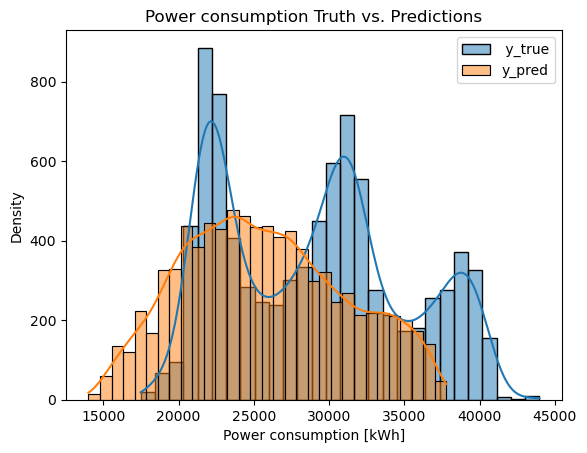

In [11]:
# Histplot of The actudal and the predicted grades
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(y_test**2, label=' y_true', kde=True, line_kws={'color': 'green'})
sns.histplot(y_pred**2, label='y_pred', kde=True, line_kws={'color': 'red'})

# Set plot labels and title
plt.xlabel('Power consumption [kWh]')
plt.ylabel('Density')
plt.title('Power consumption Truth vs. Predictions')

# Set the y-axis tick locations and labels
#plt.xticks([i/2 for i in range(21)])

#plt.xlim(15000, 45000)

# Add legend
plt.legend()

# Display the plot
plt.show()

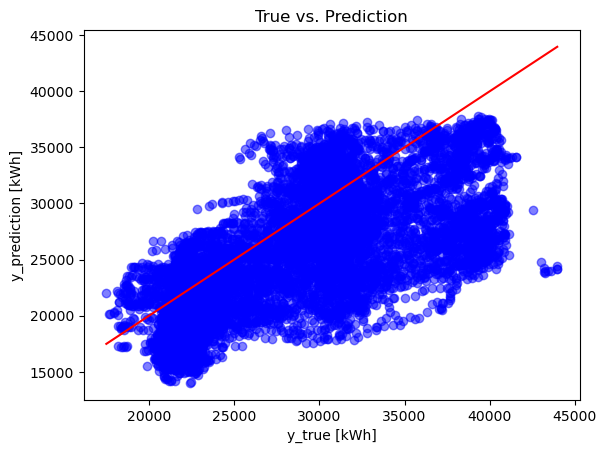

In [12]:
# Plot actual Vs. Predicted 



import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.scatter(y_test**2, y_pred**2, color='blue', alpha=0.5)

# Add a diagonal line indicating perfect predictions
plt.plot([min(y_test**2), max(y_test**2)], [min(y_test**2), max(y_test**2)], color='red')

# Set plot labels and title
plt.xlabel('y_true [kWh]')
plt.ylabel('y_prediction [kWh]')
plt.title('True vs. Prediction')

# Display the plot
plt.show()

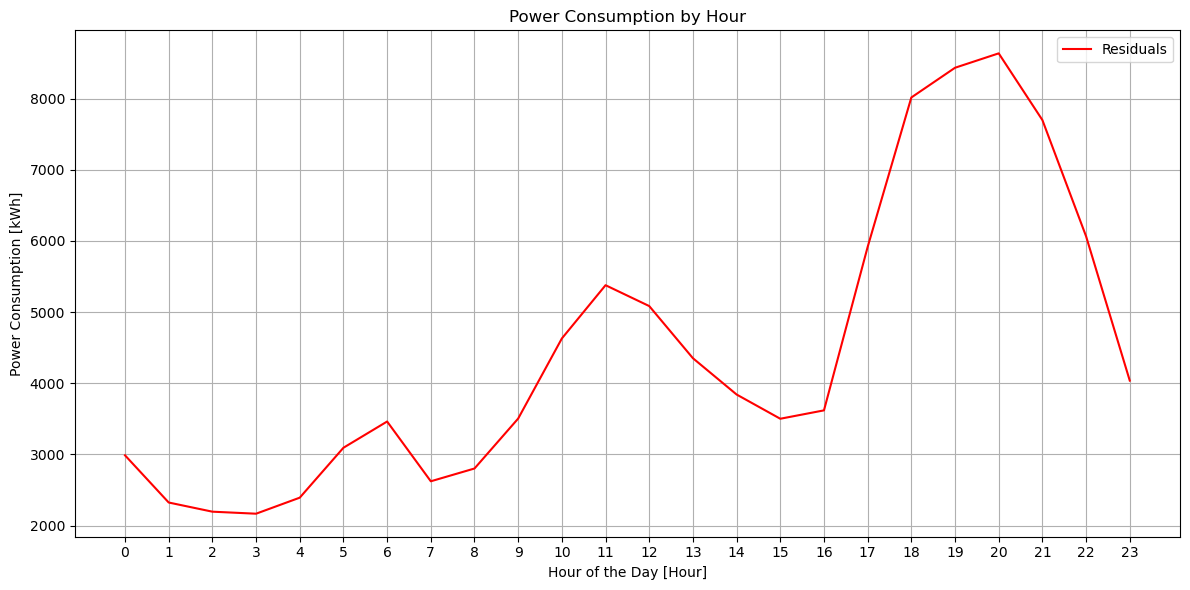

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Group the residuals by hour and calculate the mean
residuals_by_hour = residuals.groupby(X_test['Hour']).mean()

# Get the unique hours
hours = np.sort(X_test['Hour'].unique())



# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))


# Plot the residual line
ax.plot(hours, residuals_by_hour.values, label='Residuals', color='red')

# Set labels and titles
ax.set_xlabel('Hour of the Day [Hour]')
ax.set_ylabel('Power Consumption [kWh]')
ax.set_title('Power Consumption by Hour')

# Set x-axis tick locations and labels
ax.set_xticks(hours)
ax.set_xticklabels([str(h) for h in hours])

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


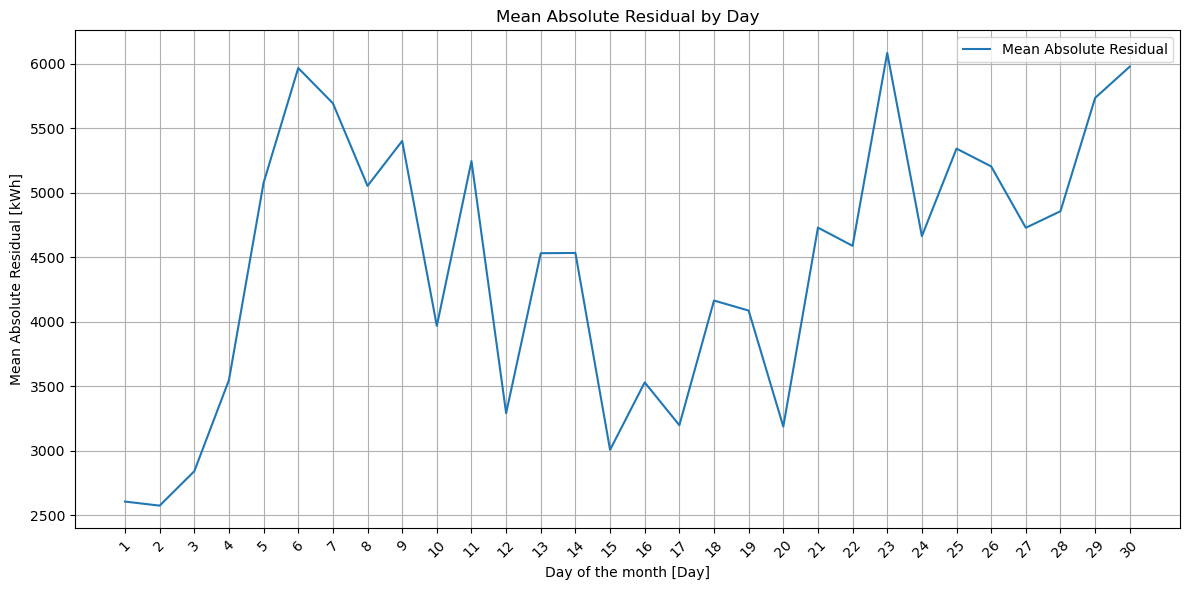

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Create a DataFrame with the daily data and residuals
daily_data = pd.DataFrame({'Day': test['Day'], 'Residuals': abs(residuals)})

# Group the data by 'Day' and calculate the mean absolute residual
mean_abs_residuals = daily_data.groupby('Day')['Residuals'].mean()

# Get the unique days
days = mean_abs_residuals.index

# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mean absolute residual against the 'Day'
ax.plot(days, mean_abs_residuals.values, label='Mean Absolute Residual')

# Set labels and title
ax.set_xlabel('Day of the month [Day]')
ax.set_ylabel('Mean Absolute Residual [kWh]')
ax.set_title('Mean Absolute Residual by Day')

# Set x-axis tick labels
ax.set_xticks(days)
ax.set_xticklabels([str(day) for day in days], rotation=45)

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


## minmax scaler

In [17]:
X_train_normalized = scaler2.fit_transform(X_train)
X_train_reshaped = np.reshape(X_train_normalized, (X_train_normalized.shape[0], 1, X_train_normalized.shape[1]))
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=64,activation='sigmoid', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Define the pipeline
pipeline = Pipeline([
    ('scaler', scaler2),
    ('reshape', ReshapeTransformer()),
   ('lstm', KerasRegressor(model=create_lstm_model, epochs=50, batch_size=32, optimizer='adam'))
])
param_grid = {  }

# Perform grid search using GridSearchCV with TimeSeriesSplit and the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv,n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred4 = best_model.predict(X_test)
# Evaluate the performance on the validation fold (e.g., calculate MSE, R-squared, etc.)
mse = mean_squared_error(y_test, y_pred4)
mae = mean_absolute_error(y_test, y_pred4)
r2 = r2_score(y_test, y_pred4)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)


Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "C:\Users\Hooi Ing Teoh\anaconda3\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\Hooi Ing Teoh\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 566, in run
    self.terminate_broken(bpe)
  File "C:\Users\Hooi Ing Teoh\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 750, in terminate_broken
    self.kill_workers(reason="broken executor")
  File "C:\Users\Hooi Ing Teoh\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py", line 781, in kill_workers
    recursive_terminate(p)
  File "C:\Users\Hooi Ing Teoh\anaconda3\lib\site-packages\joblib\externals\loky\backend\utils.py", line 26, in recursive_terminate
    _recursive_terminate_with_psutil(process)
  File "C:\Users\Hooi Ing Teoh\anaconda3\lib\site-packages\joblib\externals\loky\backend\utils.py", line 33, in _recursive_terminate_with_psutil
    c

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
X_train_normalized = scaler2.fit_transform(X_train)
X_train_reshaped = np.reshape(X_train_normalized, (X_train_normalized.shape[0], 1, X_train_normalized.shape[1]))
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=64,activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Define the pipeline
pipeline = Pipeline([
    ('scaler', scaler2),
    ('reshape', ReshapeTransformer()),
   ('lstm', KerasRegressor(model=create_lstm_model, epochs=50, batch_size=32, optimizer='adam'))
])
param_grid = {  }

# Perform grid search using GridSearchCV with TimeSeriesSplit and the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv,n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred5 = best_model.predict(X_test)
# Evaluate the performance on the validation fold (e.g., calculate MSE, R-squared, etc.)
mse = mean_squared_error(y_test, y_pred5)
mae = mean_absolute_error(y_test, y_pred5)
r2 = r2_score(y_test, y_pred5)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)


In [ ]:
X_train_normalized = scaler2.fit_transform(X_train)
X_train_reshaped = np.reshape(X_train_normalized, (X_train_normalized.shape[0], 1, X_train_normalized.shape[1]))
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=64,activation='tanh', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Define the pipeline
pipeline = Pipeline([
    ('scaler', scaler2),
    ('reshape', ReshapeTransformer()),
   ('lstm', KerasRegressor(model=create_lstm_model, epochs=50, batch_size=32, optimizer='adam'))
])
param_grid = {  }

# Perform grid search using GridSearchCV with TimeSeriesSplit and the pipeline
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv,n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred6 = best_model.predict(X_test)
# Evaluate the performance on the validation fold (e.g., calculate MSE, R-squared, etc.)
mse = mean_squared_error(y_test, y_pred6)
mae = mean_absolute_error(y_test, y_pred6)
r2 = r2_score(y_test, y_pred6)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)


## residual plot

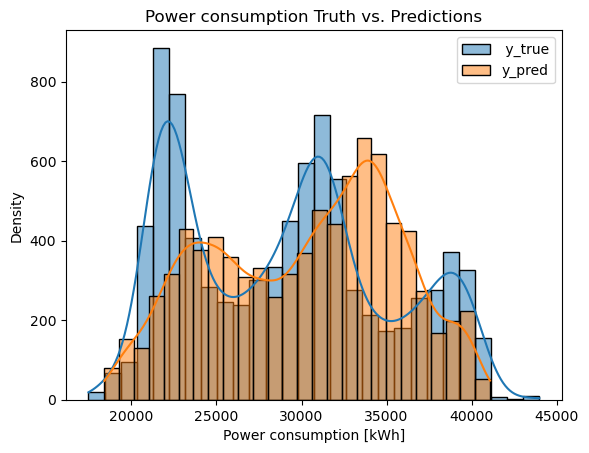

In [31]:
# Histplot of The actudal and the predicted grades
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(y_test**2, label=' y_true', kde=True, line_kws={'color': 'green'})
sns.histplot(y_pred**2, label='y_pred', kde=True, line_kws={'color': 'red'})

# Set plot labels and title
plt.xlabel('Power consumption [kWh]')
plt.ylabel('Density')
plt.title('Power consumption Truth vs. Predictions')

# Set the y-axis tick locations and labels
#plt.xticks([i/2 for i in range(21)])

#plt.xlim(15000, 45000)

# Add legend
plt.legend()

# Display the plot
plt.show()

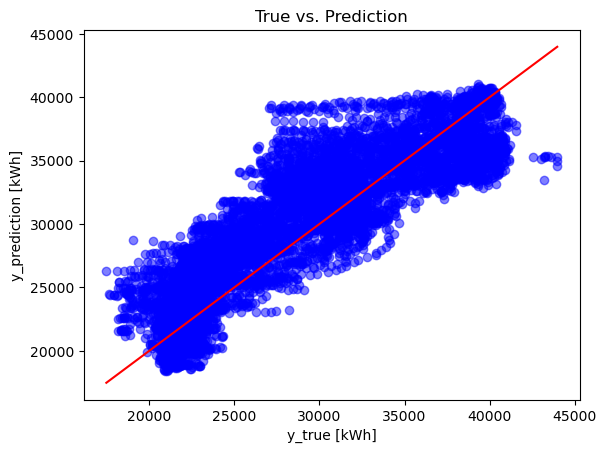

In [32]:
# Plot actual Vs. Predicted 



import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.scatter(y_test**2, y_pred**2, color='blue', alpha=0.5)

# Add a diagonal line indicating perfect predictions
plt.plot([min(y_test**2), max(y_test**2)], [min(y_test**2), max(y_test**2)], color='red')

# Set plot labels and title
plt.xlabel('y_true [kWh]')
plt.ylabel('y_prediction [kWh]')
plt.title('True vs. Prediction')

# Display the plot
plt.show()

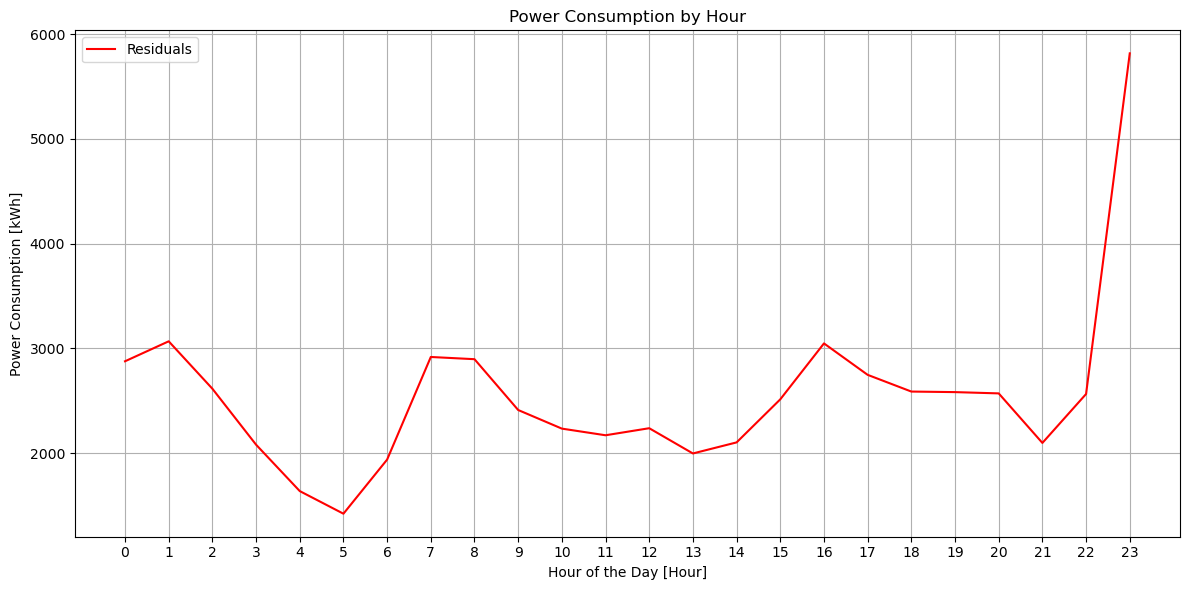

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Group the residuals by hour and calculate the mean
residuals_by_hour = residuals.groupby(X_test['Hour']).mean()

# Get the unique hours
hours = np.sort(X_test['Hour'].unique())



# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))


# Plot the residual line
ax.plot(hours, residuals_by_hour.values, label='Residuals', color='red')

# Set labels and titles
ax.set_xlabel('Hour of the Day [Hour]')
ax.set_ylabel('Power Consumption [kWh]')
ax.set_title('Power Consumption by Hour')

# Set x-axis tick locations and labels
ax.set_xticks(hours)
ax.set_xticklabels([str(h) for h in hours])

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


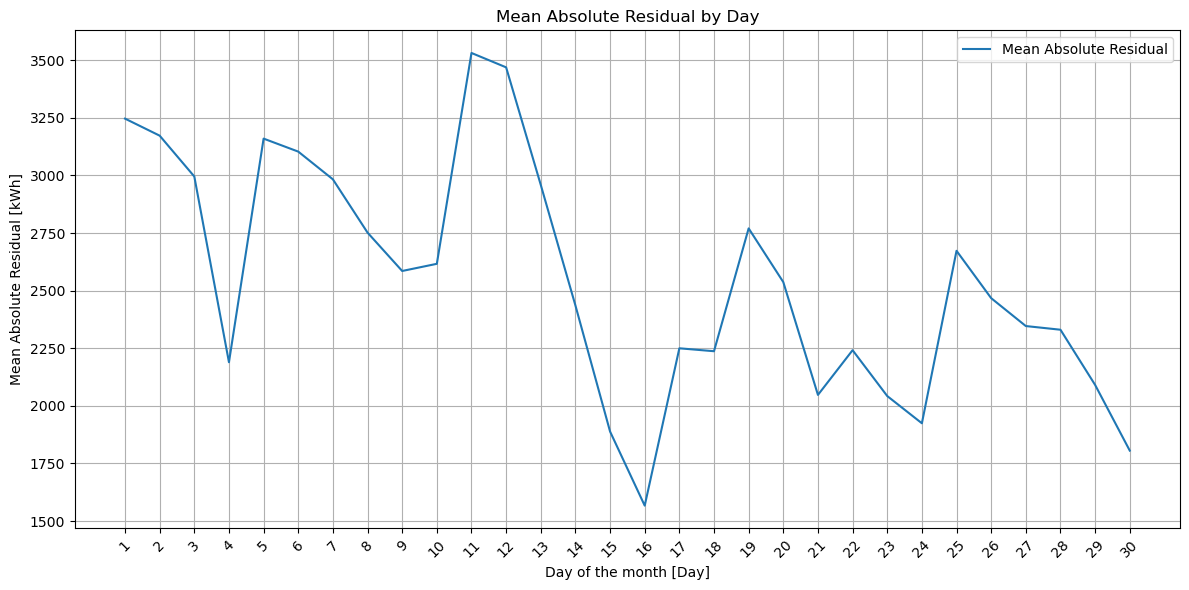

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Create a DataFrame with the daily data and residuals
daily_data = pd.DataFrame({'Day': test['Day'], 'Residuals': abs(residuals)})

# Group the data by 'Day' and calculate the mean absolute residual
mean_abs_residuals = daily_data.groupby('Day')['Residuals'].mean()

# Get the unique days
days = mean_abs_residuals.index

# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mean absolute residual against the 'Day'
ax.plot(days, mean_abs_residuals.values, label='Mean Absolute Residual')

# Set labels and title
ax.set_xlabel('Day of the month [Day]')
ax.set_ylabel('Mean Absolute Residual [kWh]')
ax.set_title('Mean Absolute Residual by Day')

# Set x-axis tick labels
ax.set_xticks(days)
ax.set_xticklabels([str(day) for day in days], rotation=45)

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()
